**Vertebral Column Data Set**

This Biomedical data set was built by Dr. Henrique da Mota during a medical residence
period in Lyon, France. Each patient in the data set is represented in the data set
by six biomechanical attributes derived from the shape and orientation of the pelvis
and lumbar spine (in this order): pelvic incidence, pelvic tilt, lumbar lordosis angle,
sacral slope, pelvic radius and grade of spondylolisthesis. The following convention is
used for the class labels: DH (Disk Hernia), Spondylolisthesis (SL), Normal (NO) and
Abnormal (AB). In this exercise, we only focus on a binary classification task NO=0
and AB=1.


In [1]:
# import all the packages
import operator
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
import csv
from beautifultable import BeautifulTable


from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

In [2]:
classNames = ['normal','abnormal']

featureNames = ['pelvic_incidence','pelvic_tilt', 'lumbar_lordosis_angle','sacral_slope',
                'pelvic_radius', 'grade_of_spondylolisthesis']

**(a) Download the Vertebral Column Data Set from: https://archive.ics.uci.edu/ml/datasets/Vertebral+Column**


In [3]:
# data prepartion -> dumping from .dat to .csv for easier access and data manipulation.

data = open('../data/vertebral_column_data/column_2C.dat').readlines()
data = [example.split() for example in data]

columnNames = featureNames + ['class']
df = pd.DataFrame(columns= columnNames, data = data)

df.loc[df['class'] == 'NO', ['class']] = 0
df.loc[df['class'] == 'AB', ['class']] = 1
df.to_csv('../data/vertebral_column_data/column_2C.csv', index =False)

**(b) Pre-Processing and Exploratory data analysis:**    


**1.Make scatterplots of the independent variables in the dataset. Use color to
show Classes 0 and 1**


**Class 0 -> NO (Blue) and Class 1 -> AB (Yellow)**

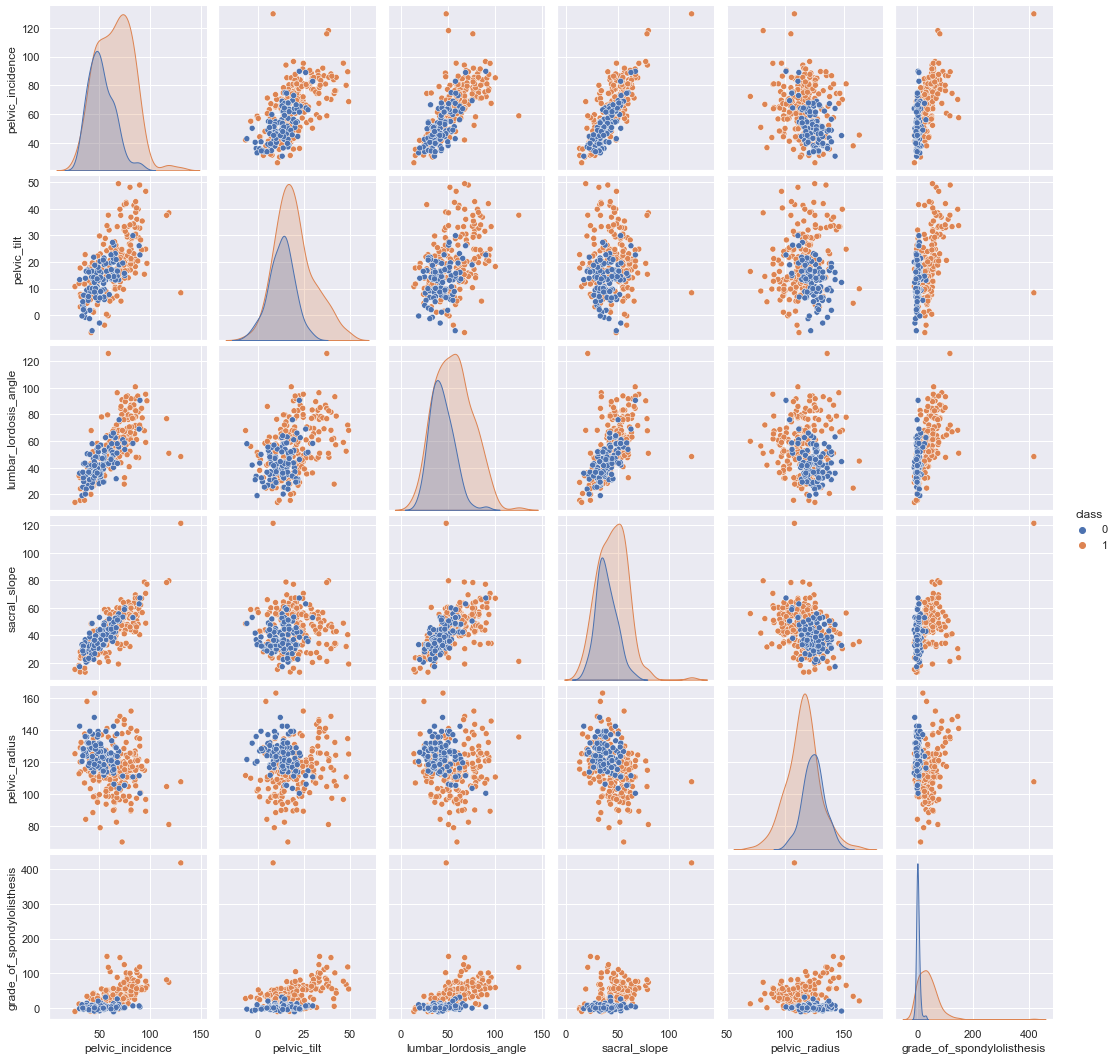

In [4]:
# question 1. (b). i
dataFrame = pd.read_csv('../data/vertebral_column_data/column_2C.csv')
sea.set()
sea.pairplot(dataFrame, hue= 'class', vars= featureNames)
plt.show()

**(b) 2. Make boxplots for each of the independent variables.  
Use color to show Classes 0 and 1**

In [5]:
def drawBoxPlot(dataFrame):
    '''
    Draw the box plot for all the independent varaiables in the dataset.
    '''
    # creating a 1 x 6 subplot for better visualization of bo
    fig, ax = plt.subplots(nrows= len(featureNames), ncols= 1, figsize= (4, 40), sharex= False)
    
    for i,feature in enumerate(featureNames):
        sea.boxplot(x= 'class', y= feature, data= dataFrame, hue= 'class', ax= ax[i])
    
    
    plt.show()
    

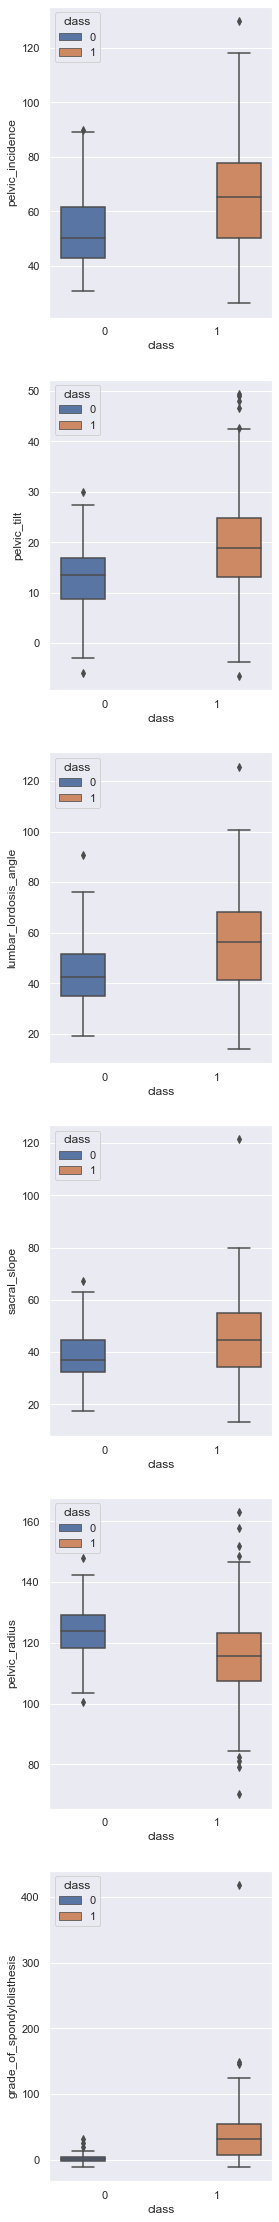

In [6]:
drawBoxPlot(dataFrame)

**(b) 3. Select the first 70 rows of Class 0 and the first 140 rows of Class 1 as the
training set and the rest of the data as the test set.**

In [7]:
def getTrainAndTestData(dataX, dataY):
    '''
    Extracts the first 70 rows of Class 0 ans first 140 rows of class 1 from given dataset.
    Ret: returns a tuple of Training and Testing features and corrosponding labels
    '''
    train_dataX = []
    train_dataY = []
    test_dataX = []
    test_dataY = []
    trainNO_count = 0
    trainAB_count = 0

    for i in range(0, (dataY.size)):
        if dataY.iloc[i] == 0:
            # first 70 examples will go in training set 
            if trainNO_count < 70:
                train_dataX.append(dataX.iloc[i,:].tolist())
                train_dataY.append(dataY.iloc[i].tolist())
                trainNO_count += 1
            else:
                test_dataX.append(dataX.iloc[i,:].tolist())
                test_dataY.append(dataY.iloc[i].tolist())
        else:
            # first 140 examples will go in training set
            if trainAB_count < 140:
                train_dataX.append(dataX.iloc[i,:].tolist())
                train_dataY.append(dataY[i].tolist())
                trainAB_count += 1
            else:
                test_dataX.append(dataX.iloc[i,:].tolist())
                test_dataY.append(dataY.iloc[i].tolist())

    train_dataX = np.asarray(train_dataX)
    train_dataX = train_dataX.astype(np.float64)
    
    train_dataY = np.asarray(train_dataY)
    
    test_dataX = np.asarray(test_dataX)
    test_dataX = test_dataX.astype(np.float64)
    
    test_dataY = np.asarray(test_dataY)
    
    return (train_dataX, train_dataY, test_dataX, test_dataY)

In [8]:
train_dataX, train_dataY, test_dataX, test_dataY = getTrainAndTestData(dataFrame.iloc[:, :-1], dataFrame.iloc[:, 6])

**(c) Classification using KNN on Vertebral Column Data Set**  

**1. Write code for k-nearest neighbors with Euclidean metric (or use a software
package)**

In [9]:
def calcCovMatrix(data_X):
    '''
    calculates covarience of input feature
    matrix as required for mahalanobis metric.
    '''
    df = pd.DataFrame(data_X)
    cov = df.cov()
    cov_matrix = np.linalg.pinv(cov.to_numpy())
    return cov_matrix

In [10]:
def formatOutputToTable(table_headers, table_data):
    '''
    to format the output in a table visualized format
    '''
    table = BeautifulTable(maxwidth= 100)
    table.column_headers = table_headers
    for i in range(0, len(table_data)):
        table.append_row(table_data[i])
    
    print(table)


In [11]:
def plot_train_test_error(train_error_dict, test_error_dict,
                          metric, train_label, test_label,
                          start_K, end_K):
    '''
    plots the training and test error with corrosponding titles and labels
    '''
    #plot K vs all training errors
    plt.plot(list(train_error_dict.keys()), list(train_error_dict.values()), 'r', label= train_label)
        
    # plot K vs all testing errors
    plt.plot(list(test_error_dict.keys()), list(test_error_dict.values()), 'b', label= test_label)
    
    plt.title('Error vs K value using ' + metric + ' distance metric')
    plt.xlim(start_K, end_K)
    plt.ylabel('Error')
    plt.xlabel('K value')
    plt.legend()
    plt.show()
    

In [12]:
def get_evaluation_metrics(error_dict, confusion_matrix_dict):
    '''
    returns the evaluation metric - 
    True Positive Rate, True Negative Rate, Precision and F1Score
    
    '''
    # sort error dictionary based on dictionary values (key : K value , val: error)
    sorted_error = sorted(error_dict.items(), key=operator.itemgetter(1))

    # Value of K with least error
    best_k = sorted_error[0][0]
    lowest_error = sorted_error[0][1]

    # Confusion matrix
    confusion_matrix = confusion_matrix_dict[best_k]

    # True Positive, True Negative, False Positive and False Negative
    true_positive = confusion_matrix[0][0]
    false_negative = confusion_matrix[0][1]
    false_positive = confusion_matrix[1][0]
    true_negative = confusion_matrix[1][1]
    
    # True Positive Rate, True Negative Rate, Precision and F1-Score
    true_positive_rate = round(true_positive / (true_positive + false_negative), 2)
    true_negative_rate = round(true_negative / (true_negative + false_positive), 2)
    
    precision = round(true_positive / (true_positive + false_positive), 2)
    recall = round(true_positive / (true_positive + false_negative), 2)
    f1_score = round((2 * precision * recall) / (precision + recall), 2)

    eval_metrics = []
    eval_metrics.append(best_k)
    eval_metrics.append(lowest_error)
    eval_metrics.append(confusion_matrix)
    eval_metrics.append(true_positive_rate)
    eval_metrics.append(true_negative_rate)
    eval_metrics.append(precision)
    eval_metrics.append(recall)
    eval_metrics.append(f1_score)

    return eval_metrics

In [13]:
def KNN(train_dataX, train_dataY, test_dataX, test_dataY,
        p, polling, metric,
        start_K, end_K, change_K):
    '''
    Builds a KNN classifier with given paramters
    '''
    error_dict = {}
    confusion_matrix_dict = {}
    while True:
        if metric == 'minkowski':
            KNN = KNeighborsClassifier(n_neighbors= start_K, 
                                       metric= metric,
                                       p= p,
                                       weights= polling)
        
        elif metric == 'mahalanobis':
            data_X = np.concatenate((train_dataX, test_dataX), axis=0)
            
            # calculating covariance matrix
            cov_matrix = calcCovMatrix(data_X)
            
            KNN = KNeighborsClassifier(n_neighbors= start_K, 
                                       algorithm= 'brute',
                                       metric= metric,
                                       metric_params= {'VI': cov_matrix},
                                       weights= polling)
        
        
        else:
            KNN = KNeighborsClassifier(n_neighbors= start_K, 
                                       metric= metric,
                                       weights= polling)
        
        # Fit training data on KNN model
        KNN.fit(train_dataX, train_dataY)
        
        # get predictions on test data
        pred_Y = KNN.predict(test_dataX)
        
        # compute prediction error on test data 
        accuracy = KNN.score(test_dataX, test_dataY)
        error_dict[start_K] = 1 - round(accuracy, 3)
        
        # compute confusion matrix
        confusion_matrix_dict[start_K] = confusion_matrix(test_dataY,
                                                          pred_Y,
                                                          labels = [1, 0])


        if start_K == end_K:
            break
        
        start_K += change_K
        
        if start_K > len(train_dataX):
            break

    return error_dict, confusion_matrix_dict
    

In [14]:
final_training_error = {}
def run_classifier(train_dataX, train_dataY, test_dataX, test_dataY,
                   p, polling, metric, start_K, end_K, change_K,is_plot):
    '''
    performs KNN classification
    ret- returns tuple of all the evaluation metrics for the best K value (list),
    along with the lowest training error achieved.
    '''
    # computing training errors
    train_error_dict, train_confusion_matrix_dict = KNN(train_dataX,
                                                        train_dataY,
                                                        train_dataX,
                                                        train_dataY,
                                                        p, polling, metric,
                                                        start_K, end_K, change_K)
    for key, val in train_error_dict.items():
        final_training_error[str(key) + metric + polling] = val
    
    # computing test errors
    test_error_dict, test_confusion_matrix_dict = KNN(train_dataX,
                                                      train_dataY,
                                                      test_dataX,
                                                      test_dataY,
                                                      p, polling, metric,
                                                      start_K, end_K, change_K)
    if is_plot:
        plot_train_test_error(train_error_dict,
                              test_error_dict,
                              metric, 'Train Error', 'Test Error',
                              start_K, end_K)
    
    return get_evaluation_metrics(test_error_dict, test_confusion_matrix_dict)
    

**KNN with euclidean evaluation metric**

**(C) ii.
Test all the data in the test database with k nearest neighbors. Take decisions by majority polling. Plot train and test errors in terms of k for k ∈ { 208,205, . . . ,7,4,1,} (in reverse order). You are welcome to use smaller
increments of k. Which k' is the most suitable k among those values? Calculate the confusion matrix, true positive rate, true negative rate, precision, and F1 score when k = k'**


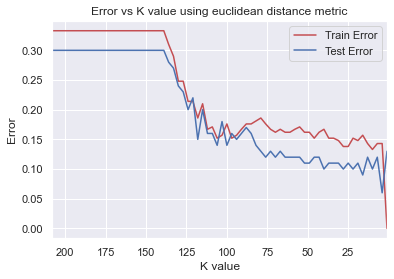

+--------+-------------+------------+--------------+---------------+-----------+--------+----------+
| Best K | Least Test  | Confusion  | True Positiv | True Negative | Precision | Recall | F1-Score |
|        |    Error    |   Matrix   |    e Rate    |      Rate     |           |        |          |
+--------+-------------+------------+--------------+---------------+-----------+--------+----------+
|   4    |    0.06     |  [[69  1]  |     0.99     |     0.83      |   0.93    |  0.99  |   0.96   |
|        |             |  [ 5 25]]  |              |               |           |        |          |
+--------+-------------+------------+--------------+---------------+-----------+--------+----------+


/Users/prince/opt/anaconda3/envs/realize/lib/python3.8/site-packages/beautifultable/utils.py:125: FutureWarning: 'BeautifulTable.column_headers' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTColumnCollection.header' instead.
  warnings.warn(message, FutureWarning)
/Users/prince/opt/anaconda3/envs/realize/lib/python3.8/site-packages/beautifultable/utils.py:125: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


In [15]:
start_K = 208
end_K = 1
change_K = -3
metric = 'euclidean'
polling = 'uniform'
p = 2
eval_metrics = run_classifier(train_dataX, train_dataY, test_dataX, test_dataY, 
                              p, polling, metric,
                              start_K, end_K, change_K,
                              True)
tableHeaders = ["Best K", "Least Test Error", "Confusion Matrix", "True Positive Rate", 
                "True Negative Rate","Precision","Recall","F1-Score"]

formatOutputToTable(tableHeaders, [eval_metrics])

**(C) iii. Learning Curve**

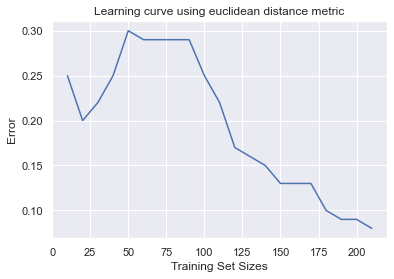

+---------+--------+-----------+-----------+------------+--------------+-------+--------+----------+
| Trainin | Best K | Least Tes | Confusion | True Posit | True Negativ | Preci | Recall | F1-Score |
| g Size  |        |  t Error  |   Matrix  |  ive Rate  |    e Rate    | sion  |        |          |
+---------+--------+-----------+-----------+------------+--------------+-------+--------+----------+
|   10    |   1    |   0.25    | [[65  5]  |    0.93    |     0.33     | 0.76  |  0.93  |   0.84   |
|         |        |           |  [20 10]] |            |              |       |        |          |
+---------+--------+-----------+-----------+------------+--------------+-------+--------+----------+
|   20    |   6    |    0.2    | [[66  4]  |    0.94    |     0.47     |  0.8  |  0.94  |   0.86   |
|         |        |           |  [16 14]] |            |              |       |        |          |
+---------+--------+-----------+-----------+------------+--------------+-------+--------+--

/Users/prince/opt/anaconda3/envs/realize/lib/python3.8/site-packages/beautifultable/utils.py:125: FutureWarning: 'BeautifulTable.column_headers' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTColumnCollection.header' instead.
  warnings.warn(message, FutureWarning)
/Users/prince/opt/anaconda3/envs/realize/lib/python3.8/site-packages/beautifultable/utils.py:125: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


In [16]:
table_data = []
train_N_start = 10
train_N_increment = 10
train_N_end = 210
error_dict = {}
while train_N_start <= train_N_end:
    NO_class_count = int(train_N_start/3)
    AB_class_count = train_N_start - NO_class_count
    
    df_NO = dataFrame[dataFrame['class'] == 0]
    df_AB = dataFrame[dataFrame['class'] == 1]
    
    data_NO_X = df_NO.iloc[:,:-1].to_numpy()
    data_NO_Y = df_NO.iloc[:,6].to_numpy()
    
    data_AB_X = df_AB.iloc[:,:-1].to_numpy()
    data_AB_Y = df_AB.iloc[:,6].to_numpy()
    
    train_data_X = np.concatenate((data_NO_X[:NO_class_count], data_AB_X[:AB_class_count]), axis=0)
    train_data_Y = np.concatenate((data_NO_Y[:NO_class_count], data_AB_Y[:AB_class_count]), axis=0)
    train_data_X = train_data_X.astype(np.float64)

    metric = 'euclidean'
    polling = 'uniform'
    start_K = 1
    end_K = 196
    change_K = 5
    eval_metrics = run_classifier(train_data_X, train_data_Y,
                                  test_dataX, test_dataY, 
                                  2, polling, metric,
                                  start_K, end_K, change_K,
                                  False)
    
    error_dict[train_N_start] = eval_metrics[1]
    eval_metrics.insert(0, train_N_start)
    table_data.append(eval_metrics)

    train_N_start += train_N_increment
    
plt.plot(list(error_dict.keys()), list(error_dict.values()), 'b')
plt.title('Learning curve using ' + metric + ' distance metric')
plt.ylabel('Error')
plt.xlabel('Training Set Sizes')
plt.show()

table_headers = ["Training Size", "Best K", "Least Test Error", "Confusion Matrix", 
                "True Positive Rate", "True Negative Rate","Precision", "Recall","F1-Score"]
formatOutputToTable(table_headers, table_data)

**(d) 1. (A) KNN with Manhattan Distance and majority pooling**

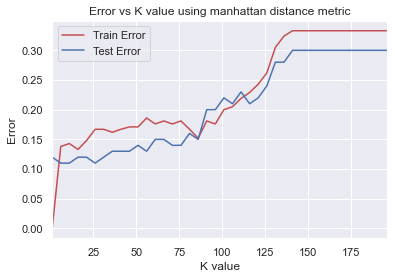

In [17]:


compare_data_metrics = []

start_K = 1
end_K = 196
change_K = 5
metric = 'manhattan'
polling = 'uniform'
p = 1

eval_metrics = run_classifier(train_dataX, train_dataY, test_dataX, test_dataY, 
                              p, polling, metric,
                              start_K, end_K, change_K,
                              True)
eval_metrics.insert(0, metric)
compare_data_metrics.append(eval_metrics)

**(d) 1. (B) KNN with Minkowski Distance by varying log P**

In [18]:
def getPError(train_dataX, train_dataY, 
                  test_dataX, test_dataY, K, metric, polling):
    '''
    calculates log error for various various values of P
    '''
    log_P_start = 0.1
    log_P_increment = 0.1
    best_log_p_val = 0
    error_dict = {}
    
    # compute testing error for different values of logP
    while log_P_start <= 1.0:
        
        # round off 10^logP value to nearest integer
        p = round(math.pow(10, log_P_start))
        KNN = KNeighborsClassifier(n_neighbors= K,
                                   metric= metric,
                                   p= p,
                                   weights= polling)
        
        # fit training data on KNN model
        KNN.fit(train_dataX, train_dataY)
        
        pred_Y = KNN.predict(test_dataX)
        correct_pred = np.sum(pred_Y == test_dataY)
        
        accuracy = float(correct_pred) / len(test_dataY)
        error = 1 - round(accuracy, 3)
        error_dict[log_P_start] = error
        log_P_start = ((log_P_start*10) + (log_P_increment*10))/10

    return error_dict

In [19]:
start_K = 1
end_K = 196
change_K = 5

metric = 'minkowski'
polling = 'uniform'

K = eval_metrics[1]
error_dict = getPError(train_dataX, train_dataY,
                      test_dataX, test_dataY, K, metric, polling)

log_p_data = []

for k, v in error_dict.items():
    log_p_data.append([k, v])

print('Test Error as a function of log P')
table_headers = ["logP", "Test Error"]

formatOutputToTable(table_headers, log_p_data)

sorted_error = sorted(error_dict.items(), key=operator.itemgetter(1))
print('Best value of logP: {0} with test error: {1}'.format(sorted_error[0][0], round(sorted_error[0][1], 2)))

Test Error as a function of log P
+------+------------+
| logP | Test Error |
+------+------------+
| 0.1  |    0.11    |
+------+------------+
| 0.2  |    0.08    |
+------+------------+
| 0.3  |    0.08    |
+------+------------+
| 0.4  |    0.08    |
+------+------------+
| 0.5  |    0.08    |
+------+------------+
| 0.6  |    0.06    |
+------+------------+
| 0.7  |    0.07    |
+------+------------+
| 0.8  |    0.08    |
+------+------------+
| 0.9  |    0.09    |
+------+------------+
| 1.0  |    0.09    |
+------+------------+
Best value of logP: 0.6 with test error: 0.06


/Users/prince/opt/anaconda3/envs/realize/lib/python3.8/site-packages/beautifultable/utils.py:125: FutureWarning: 'BeautifulTable.column_headers' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTColumnCollection.header' instead.
  warnings.warn(message, FutureWarning)
/Users/prince/opt/anaconda3/envs/realize/lib/python3.8/site-packages/beautifultable/utils.py:125: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


**(d) 1. (C) KNN with Chebyshev Distance**

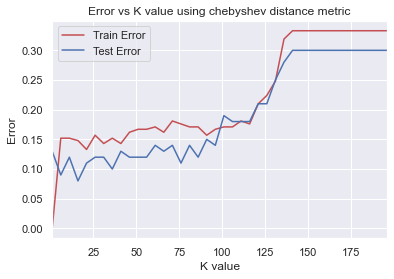

In [20]:
start_K = 1
end_K = 196
change_K = 5
p = 0

metric = 'chebyshev'
polling = 'uniform'
eval_metrics = run_classifier(train_dataX, train_dataY, test_dataX, test_dataY, 
                              p, polling, metric,
                              start_K, end_K, change_K, True)
eval_metrics.insert(0, metric)
compare_data_metrics.append(eval_metrics)

**(d) 2. KNN with Mahalanobis Distance**

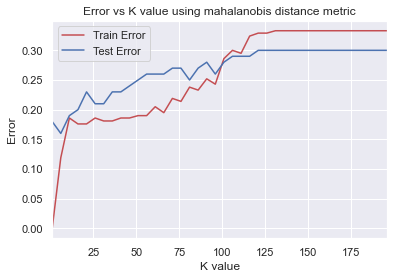

In [21]:
start_K = 1
end_K = 196
change_K = 5
p = 0

metric = 'mahalanobis'
polling = 'uniform'


eval_metrics = run_classifier(train_dataX, train_dataY, test_dataX, test_dataY, 
                              p, polling, metric,
                              start_K, end_K, change_K, True)

eval_metrics.insert(0, metric)
compare_data_metrics.append(eval_metrics)

**Comparison between different distance metrics using Uniform Polling**

In [22]:
table_headers = ["Distance Metric", "Best K", "Least Test Error", "Confusion Matrix", 
                "True Positive Rate", "True Negative Rate","Precision","Recall","F1-Score"]
formatOutputToTable(table_headers, compare_data_metrics)

+----------+--------+-----------+-----------+------------+-------------+-------+--------+----------+
| Distance | Best K | Least Tes | Confusion | True Posit | True Negati | Preci | Recall | F1-Score |
|  Metric  |        |  t Error  |   Matrix  |  ive Rate  |   ve Rate   | sion  |        |          |
+----------+--------+-----------+-----------+------------+-------------+-------+--------+----------+
| manhatta |   6    |   0.11    | [[67  3]  |    0.96    |    0.73     | 0.89  |  0.96  |   0.92   |
|    n     |        |           |           |            |             |       |        |          |
|          |        |           |  [ 8 22]] |            |             |       |        |          |
+----------+--------+-----------+-----------+------------+-------------+-------+--------+----------+
| chebyshe |   16   |   0.08    | [[70  0]  |    1.0     |    0.73     |  0.9  |  1.0   |   0.95   |
|    v     |        |           |           |            |             |       |        |  

/Users/prince/opt/anaconda3/envs/realize/lib/python3.8/site-packages/beautifultable/utils.py:125: FutureWarning: 'BeautifulTable.column_headers' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTColumnCollection.header' instead.
  warnings.warn(message, FutureWarning)
/Users/prince/opt/anaconda3/envs/realize/lib/python3.8/site-packages/beautifultable/utils.py:125: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


**(e) KNN with Euclidean distance metric and weighted polling**

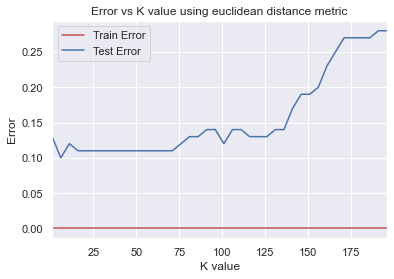

In [23]:
compare_weighted_pool_metric = []


start_K = 1
end_K = 196
change_K = 5
metric = 'euclidean'
polling = 'distance'
p = 2
eval_metrics = run_classifier(train_dataX, train_dataY, test_dataX, test_dataY, 
                              p, polling, metric,
                              start_K, end_K, change_K,
                              True)
eval_metrics.insert(0, metric+' '+polling)
compare_weighted_pool_metric.append(eval_metrics)

**(e) KNN with Manhattan distance metric and weighted polling**


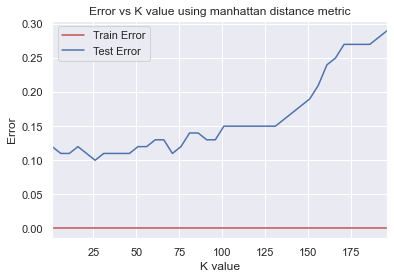

In [24]:

start_K = 1
end_K = 196
change_K = 5
metric = 'manhattan'
polling = 'distance'
p = 1

eval_metrics = run_classifier(train_dataX, train_dataY, test_dataX, test_dataY, 
                              p, polling, metric,
                              start_K, end_K, change_K,
                              True)
eval_metrics.insert(0, metric+' '+polling)
compare_weighted_pool_metric.append(eval_metrics)


**(e) KNN with Chebyshev Distance Metric and weighted polling**

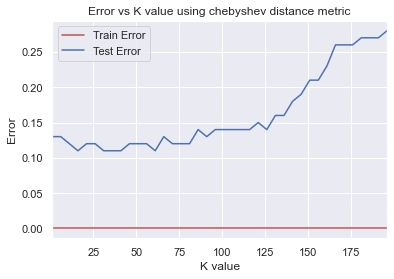

In [25]:
start_K = 1
end_K = 196
change_K = 5
p = 0

metric = 'chebyshev'
polling = 'distance'
eval_metrics = run_classifier(train_dataX, train_dataY, test_dataX, test_dataY, 
                              p, polling, metric,
                              start_K, end_K, change_K, True)

eval_metrics.insert(0, metric+' '+polling)
compare_weighted_pool_metric.append(eval_metrics)

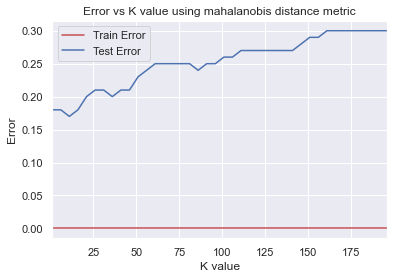

In [26]:
start_K = 1
end_K = 196
change_K = 5
p = 0

metric = 'mahalanobis'
polling = 'distance'


eval_metrics = run_classifier(train_dataX, train_dataY, test_dataX, test_dataY, 
                              p, polling, metric,
                              start_K, end_K, change_K, True)

eval_metrics.insert(0, metric+' '+polling)
compare_weighted_pool_metric.append(eval_metrics)

**Comparison between different distance metrics using weighted Polling**

In [27]:
table_headers = ["Distance Metric", "Best K", "Least Test Error", "Confusion Matrix", 
                "True Positive Rate", "True Negative Rate","Precision","Recall","F1-Score"]
formatOutputToTable(table_headers, compare_weighted_pool_metric)

+---------------+--------+----------+----------+-----------+-----------+-------+--------+----------+
| Distance Metr | Best K | Least Te | Confusio | True Posi | True Nega | Preci | Recall | F1-Score |
|      ic       |        | st Error | n Matrix | tive Rate | tive Rate | sion  |        |          |
+---------------+--------+----------+----------+-----------+-----------+-------+--------+----------+
| euclidean dis |   6    |   0.1    | [[70  0] |    1.0    |   0.67    | 0.88  |  1.0   |   0.94   |
|     tance     |        |          |          |           |           |       |        |          |
|               |        |          |  [10 20] |           |           |       |        |          |
|               |        |          |    ]     |           |           |       |        |          |
+---------------+--------+----------+----------+-----------+-----------+-------+--------+----------+
| manhattan dis |   26   |   0.1    | [[69  1] |   0.99    |    0.7    | 0.88  |  0.99  |  

/Users/prince/opt/anaconda3/envs/realize/lib/python3.8/site-packages/beautifultable/utils.py:125: FutureWarning: 'BeautifulTable.column_headers' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTColumnCollection.header' instead.
  warnings.warn(message, FutureWarning)
/Users/prince/opt/anaconda3/envs/realize/lib/python3.8/site-packages/beautifultable/utils.py:125: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


**(f) What is the lowest training error rate you achieved in this homework?**

In [28]:
sorted_final_training_error = sorted(final_training_error.items(), key=operator.itemgetter(1))
print('Lowest training error achieved: {0} , using {1} setting'.format
      (sorted_final_training_error[0][1],
       sorted_final_training_error[0][0]))

Lowest training error achieved: 0.0 , using 1euclideanuniform setting
